## MONICA Crop Model

--------------

Задачи:

* Отрисовать погоду для 2016 и 2017 годов 

* Отрисовать динамику биомассы ✅

* Сделать GA для статьи? 

* Отобразить динамику почвенных условий ✅

* Для всех рядов посчитать метрики

In [1]:
import os, sys
import json
import pandas as pd
import numpy as np 
import datetime as dt
import subprocess
import shutil

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
! pip -q install tslearn


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
! pip -q install SciencePlots


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3 -m pip install --upgrade pip


 ## 1. Save weather in proper format for MONICA

In [4]:
def weather_to_monica(src: str, dst: str, 
                      use_real_precip: bool = False,
                      correct_precip:bool=False,
                      use_history:bool=False,
                      reanalysis: str = '../monica/reanalysis.csv'): 
    weather = pd.read_csv(src)
    
    if use_real_precip: 
        era5 = pd.read_csv(reanalysis)
        if len(era5)!=len(weather):
            raise ValueError('Size of era5 and forecast should be equal')
        weather.loc[:, 'precip'] = era5.loc[:, 'precip'].copy()
        
    if use_history:
        hist = pd.read_csv('../monica/baseline_monica.csv')
        print('use hist')
        if len(hist)!=len(weather):
            raise ValueError('Size of era5 and forecast should be equal')
        weather.loc[:, 'precip'] = hist.loc[:, 'precip'].copy()
        
        
    weather.loc[:, 'de-date'] = pd.to_datetime(weather['de-date'], format="%d.%m.%Y")
    mask = weather['de-date']<'31.12.2017'
    weather = weather.loc[mask]
    weather['de-date'] = pd.to_datetime(weather['de-date']).dt.strftime('%d.%m.%Y')
    mask = weather['relhumid']>100
    weather.loc[mask, 'relhumid']=99.99
    if correct_precip:
        mask = weather['de-date']>'2017-01-01'
        sum_precip = weather.loc[mask, 'precip'].sum()
        print('sum_precip',sum_precip)
        diff = 633 - sum_precip - 90
        to_add = diff/80
        index_to_add = weather.sample(frac=0.25).index
        weather.loc[index_to_add, 'precip'] = weather.loc[index_to_add, 'precip']+ to_add
        print(weather.iloc[-365:, :]['precip'].sum())
    weather.round(2).to_csv(dst, sep=';', index=False)
    return weather

## 2. Run MONICA model 

In [5]:
# df_r = pd.read_csv('../monica/reanalysis_2016.csv')

# df_m = pd.read_csv('../monica/means_2016.csv')

# df_s = pd.read_csv('../monica/sarimax_2016.csv')

# df_p = pd.read_csv('../monica/prophet_2016.csv')

# df_np = pd.read_csv('../monica/neural_prophet_2016.csv')

# df_mp = pd.read_csv('../monica/multi-prophet_2016.csv')

In [7]:
def run_monica(climate_fname: str, 
               crop: str = 'sugar-beet',
               kind:str = 'ERA5', 
               use_real_precip:bool=False, 
               correct_precip:bool=False,
              use_history:bool=False)->pd.DataFrame:
    """
    run monica model 
    
    climate_fname: str - path to file with weather
    """
    if crop=='soyabean':
        path_sim_file = '/home/monica/monica_input/soyabean-sim.json'
    elif crop == 'sugar-beet':
        path_sim_file = '/home/monica/monica_input/sugarbeat-sim.json'
    else: 

        raise KeyError(f'crop should be sugar-beet or soyabean, but your is: {crop}')

    path_monica = '../monica/monica_input/'
    dst = os.path.join(path_monica, "climate-monica.csv")
    
    weather = weather_to_monica(src=climate_fname,
                                dst=dst, 
                                use_real_precip=use_real_precip,
                                correct_precip = correct_precip,
                                use_history=use_history)

    weather.loc[:, 'weather'] = kind
    weather['de-date'] = pd.to_datetime(weather['de-date'].apply(lambda x: dt.datetime.strptime(x,'%d.%m.%Y' )))
    cmd = 'monica-run'
    res_monica_run = subprocess.run([cmd, path_sim_file], universal_newlines=True)
#     print(res_monica_run)
    daily_monica = pd.read_csv('./out.csv', skiprows=[0,2], skipfooter=30, engine='python')
    daily_monica.loc[:, 'weather'] = kind
    return daily_monica, weather

In [29]:
df_r, w_r = run_monica(climate_fname='../monica/reanalysis_2016.csv', crop='soyabean', kind='era5')

df_b, w_b = run_monica(climate_fname='../monica/means_2016.csv', crop='soyabean', kind='baseline')

df_s, w_s = run_monica(climate_fname='../monica/sarimax_2016.csv', crop='soyabean', kind='sarimax')

df_p, w_p = run_monica(climate_fname='../monica/prophet_2016.csv', crop='soyabean', kind='prophet')

df_np, w_np = run_monica(climate_fname='../monica/neural_prophet_2016.csv', crop='soyabean', kind='neural_prophet')

df_mp, w_mp = run_monica(climate_fname='../monica/multi-prophet_2016.csv', crop='soyabean', kind='multi_prophet')

# df_n, w_n = run_monica(climate_fname='../monica/prophet_2017.csv', crop='soyabean', kind='prophet_corr', correct_precip=True)

# 3. Plots and analytics

In [30]:
import scienceplots

In [31]:
plt.style.use(['science', 'no-latex'])

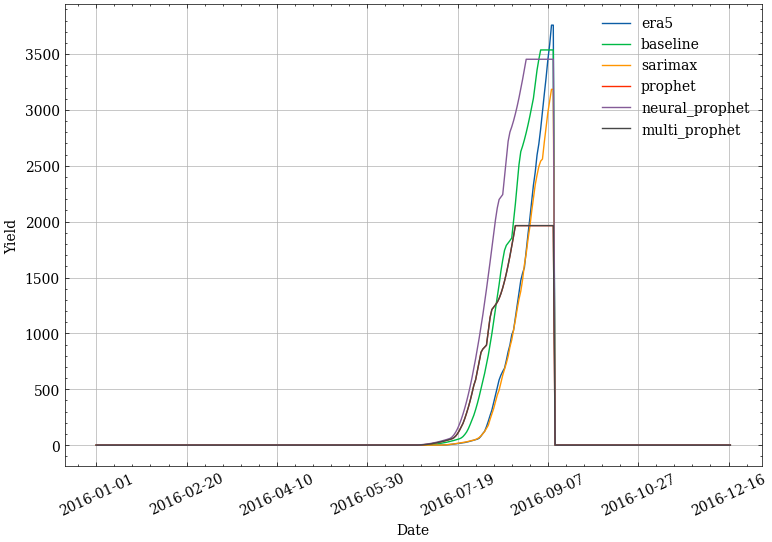

In [32]:
var = 'Yield'
fig, ax = plt.subplots(1,1,figsize = (9,6))
df_r.set_index('Date')[var].plot(label='era5')
df_b.set_index('Date')[var].plot(label='baseline')
df_s.set_index('Date')[var].plot(label='sarimax')
df_p.set_index('Date')[var].plot(label='prophet')
df_np.set_index('Date')[var].plot(label='neural_prophet')
df_mp.set_index('Date')[var].plot(label='multi_prophet')
# df_n.set_index('Date')[var].plot(label='prophet^2')
plt.ylabel(var)
plt.legend()
plt.xticks(rotation=25)
plt.grid()

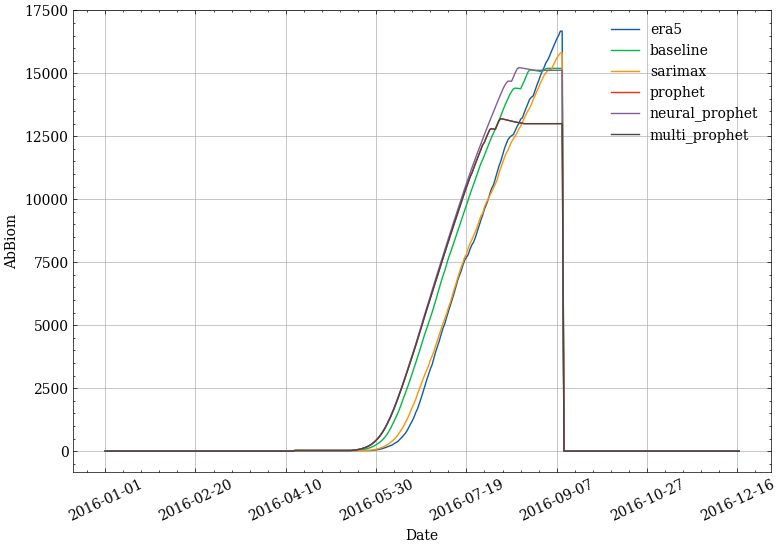

In [33]:
var = 'AbBiom'
fig, ax = plt.subplots(1,1,figsize = (9,6))
df_r.set_index('Date')[var].plot(label='era5')
df_b.set_index('Date')[var].plot(label='baseline')
df_s.set_index('Date')[var].plot(label='sarimax')
df_p.set_index('Date')[var].plot(label='prophet')
df_np.set_index('Date')[var].plot(label='neural_prophet')
df_mp.set_index('Date')[var].plot(label='multi_prophet')
plt.ylabel(var)
plt.legend()
plt.xticks(rotation=25)
plt.grid()

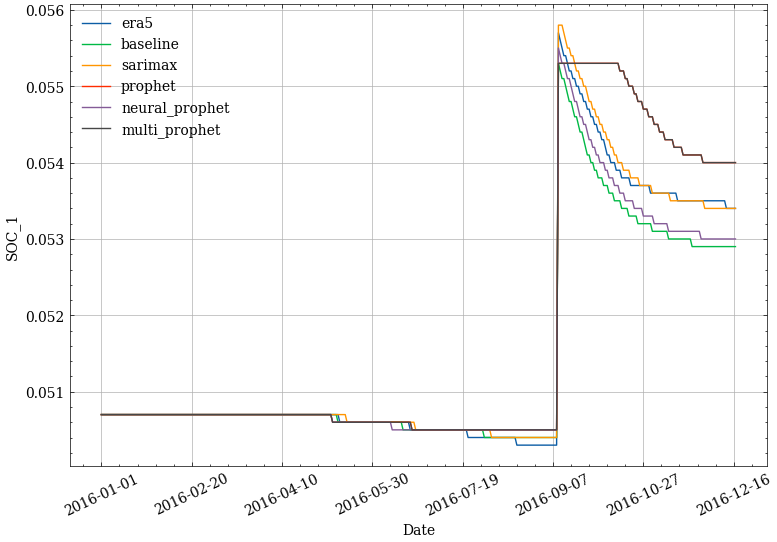

In [34]:
var = 'SOC_1'
fig, ax = plt.subplots(1,1,figsize = (9,6))
df_r.set_index('Date')[var].plot(label='era5')
df_b.set_index('Date')[var].plot(label='baseline')
df_s.set_index('Date')[var].plot(label='sarimax')
df_p.set_index('Date')[var].plot(label='prophet')
df_np.set_index('Date')[var].plot(label='neural_prophet')
df_mp.set_index('Date')[var].plot(label='multi_prophet')
plt.ylabel(var)
plt.legend()
plt.xticks(rotation=25)
plt.grid()

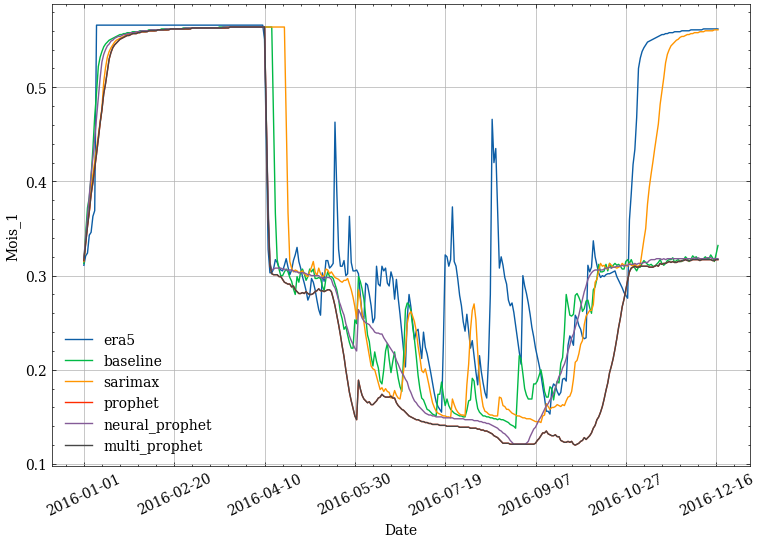

In [35]:
var = 'Mois_1'
fig, ax = plt.subplots(1,1,figsize = (9,6))
df_r.set_index('Date')[var].plot(label='era5')
df_b.set_index('Date')[var].plot(label='baseline')
df_s.set_index('Date')[var].plot(label='sarimax')
df_p.set_index('Date')[var].plot(label='prophet')
df_np.set_index('Date')[var].plot(label='neural_prophet')
df_mp.set_index('Date')[var].plot(label='multi_prophet')
plt.ylabel(var)
plt.legend()
plt.xticks(rotation=25)
plt.grid()

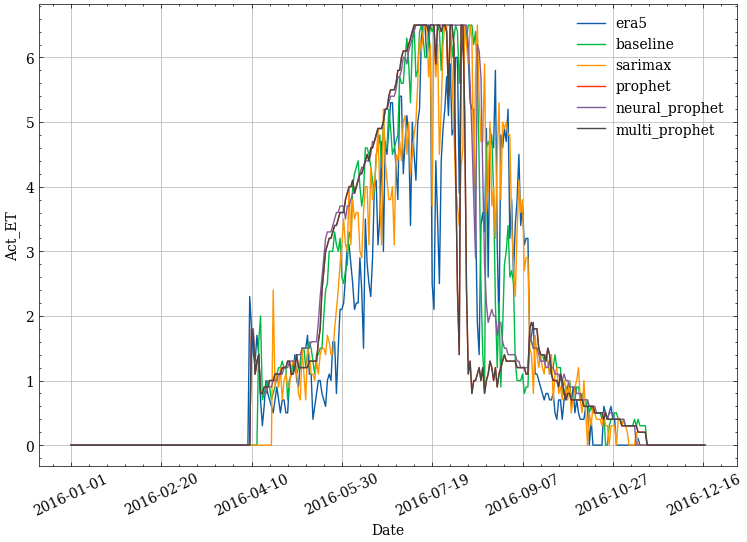

In [36]:
var = 'Act_ET'
fig, ax = plt.subplots(1,1,figsize = (9,6))
df_r.set_index('Date')[var].plot(label='era5')
df_b.set_index('Date')[var].plot(label='baseline')
df_s.set_index('Date')[var].plot(label='sarimax')
df_p.set_index('Date')[var].plot(label='prophet')
df_np.set_index('Date')[var].plot(label='neural_prophet')
df_mp.set_index('Date')[var].plot(label='multi_prophet')
plt.ylabel(var)
plt.legend()
plt.xticks(rotation=25)
plt.grid()

In [37]:
res_r_2016 = df_r[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1', 'LAI', 'NEE']].copy()
res_b_2016 = df_b[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1', 'LAI', 'NEE']].copy()
res_s_2016 = df_s[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1', 'LAI', 'NEE']].copy()
res_p_2016 = df_p[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1', 'LAI', 'NEE']].copy()
res_np_2016 = df_np[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1', 'LAI', 'NEE']].copy()
res_mp_2016 = df_mp[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1', 'LAI', 'NEE']].copy()

# Metrics 2016

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
from tslearn.metrics import dtw

def relative_rmse(target, preds):
    rmse = mean_squared_error(target, preds, squared=False)
    avg = np.full(len(preds), preds.mean())
    const_rmse = mean_squared_error(target, avg, squared=False)
    return round(rmse / const_rmse, 2)

/usr/local/lib/python3.7/dist-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [38]:
# LAI

In [39]:
print("Mean\t\t", mean_squared_error(res_r_2016['LAI'], res_b_2016['LAI']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['LAI'], res_s_2016['LAI']))
print("Prophet\t\t", mean_squared_error(res_r_2016['LAI'], res_p_2016['LAI']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['LAI'], res_np_2016['LAI']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['LAI'], res_mp_2016['LAI']))

Mean		 1.2249911717045454
Sarimax		 0.021819643948863633
Prophet		 2.002846384346591
Neural Prophet	 2.2385217444602272
Multi Prophet	 2.002846384346591


In [40]:
print("Mean\t\t", relative_rmse(res_r_2016['LAI'], res_b_2016['LAI']))
print("Sarimax\t\t", relative_rmse(res_r_2016['LAI'], res_s_2016['LAI']))
print("Prophet\t\t", relative_rmse(res_r_2016['LAI'], res_p_2016['LAI']))
print("Neural Prophet\t", relative_rmse(res_r_2016['LAI'], res_np_2016['LAI']))
print("Multi Prophet\t", relative_rmse(res_r_2016['LAI'], res_mp_2016['LAI']))

Mean		 0.32
Sarimax		 0.04
Prophet		 0.41
Neural Prophet	 0.43
Multi Prophet	 0.41


In [41]:
print("Mean\t\t", r2_score(res_r_2016['LAI'], res_b_2016['LAI']))
print("Sarimax\t\t", r2_score(res_r_2016['LAI'], res_s_2016['LAI']))
print("Prophet\t\t", r2_score(res_r_2016['LAI'], res_p_2016['LAI']))
print("Neural Prophet\t", r2_score(res_r_2016['LAI'], res_np_2016['LAI']))
print("Multi Prophet\t", r2_score(res_r_2016['LAI'], res_mp_2016['LAI']))

Mean		 0.8980373339921233
Sarimax		 0.9981838325697703
Prophet		 0.8332922214712338
Neural Prophet	 0.8136756817078366
Multi Prophet	 0.8332922214712338


In [42]:
print("Mean\t\t", dtw(res_r_2016['LAI'], res_b_2016['LAI']))
print("Sarimax\t\t", dtw(res_r_2016['LAI'], res_s_2016['LAI']))
print("Prophet\t\t", dtw(res_r_2016['LAI'], res_p_2016['LAI']))
print("Neural Prophet\t", dtw(res_r_2016['LAI'], res_np_2016['LAI']))
print("Multi Prophet\t", dtw(res_r_2016['LAI'], res_mp_2016['LAI']))

Mean		 7.688101325424895
Sarimax		 0.588883485929092
Prophet		 4.4705176702480465
Neural Prophet	 8.877642620087839
Multi Prophet	 4.4705176702480465


In [43]:
# NEE

In [44]:
print("Mean\t\t", mean_squared_error(res_r_2016['NEE'], res_b_2016['NEE']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['NEE'], res_s_2016['NEE']))
print("Prophet\t\t", mean_squared_error(res_r_2016['NEE'], res_p_2016['NEE']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['NEE'], res_np_2016['NEE']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['NEE'], res_mp_2016['NEE']))

Mean		 788.6092057590919
Sarimax		 358.33460971701646
Prophet		 2416.202581905606
Neural Prophet	 1227.5390220419993
Multi Prophet	 2416.202581905606


In [45]:
print("Mean\t\t", relative_rmse(res_r_2016['NEE'], res_b_2016['NEE']))
print("Sarimax\t\t", relative_rmse(res_r_2016['NEE'], res_s_2016['NEE']))
print("Prophet\t\t", relative_rmse(res_r_2016['NEE'], res_p_2016['NEE']))
print("Neural Prophet\t", relative_rmse(res_r_2016['NEE'], res_np_2016['NEE']))
print("Multi Prophet\t", relative_rmse(res_r_2016['NEE'], res_mp_2016['NEE']))

Mean		 0.51
Sarimax		 0.35
Prophet		 0.9
Neural Prophet	 0.64
Multi Prophet	 0.9


In [46]:
print("Mean\t\t", r2_score(res_r_2016['NEE'], res_b_2016['NEE']))
print("Sarimax\t\t", r2_score(res_r_2016['NEE'], res_s_2016['NEE']))
print("Prophet\t\t", r2_score(res_r_2016['NEE'], res_p_2016['NEE']))
print("Neural Prophet\t", r2_score(res_r_2016['NEE'], res_np_2016['NEE']))
print("Multi Prophet\t", r2_score(res_r_2016['NEE'], res_mp_2016['NEE']))

Mean		 0.7364825967292307
Sarimax		 0.8802608374780767
Prophet		 0.1926147634213652
Neural Prophet	 0.5898121742179295
Multi Prophet	 0.1926147634213652


In [47]:
print("Mean\t\t", dtw(res_r_2016['NEE'], res_b_2016['NEE']))
print("Sarimax\t\t", dtw(res_r_2016['NEE'], res_s_2016['NEE']))
print("Prophet\t\t", dtw(res_r_2016['NEE'], res_p_2016['NEE']))
print("Neural Prophet\t", dtw(res_r_2016['NEE'], res_np_2016['NEE']))
print("Multi Prophet\t", dtw(res_r_2016['NEE'], res_mp_2016['NEE']))

Mean		 326.0176502925613
Sarimax		 184.219935280327
Prophet		 280.574959329975
Neural Prophet	 280.4750549120757
Multi Prophet	 280.574959329975


In [22]:
# AbBiom

In [23]:
print("Mean\t\t", mean_squared_error(res_r_2016['AbBiom'], res_b_2016['AbBiom']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['AbBiom'], res_s_2016['AbBiom']))
print("Prophet\t\t", mean_squared_error(res_r_2016['AbBiom'], res_p_2016['AbBiom']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['AbBiom'], res_np_2016['AbBiom']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['AbBiom'], res_mp_2016['AbBiom']))

Mean		 817427.2343181818
Sarimax		 34953.10599431817
Prophet		 1526998.0581534093
Neural Prophet	 1579425.0422443182
Multi Prophet	 1526998.0581534093


In [24]:
print("Mean\t\t", relative_rmse(res_r_2016['AbBiom'], res_b_2016['AbBiom']))
print("Sarimax\t\t", relative_rmse(res_r_2016['AbBiom'], res_s_2016['AbBiom']))
print("Prophet\t\t", relative_rmse(res_r_2016['AbBiom'], res_p_2016['AbBiom']))
print("Neural Prophet\t", relative_rmse(res_r_2016['AbBiom'], res_np_2016['AbBiom']))
print("Multi Prophet\t", relative_rmse(res_r_2016['AbBiom'], res_mp_2016['AbBiom']))

Mean		 0.19
Sarimax		 0.04
Prophet		 0.27
Neural Prophet	 0.27
Multi Prophet	 0.27


In [25]:
print("Mean\t\t", r2_score(res_r_2016['AbBiom'], res_b_2016['AbBiom']))
print("Sarimax\t\t", r2_score(res_r_2016['AbBiom'], res_s_2016['AbBiom']))
print("Prophet\t\t", r2_score(res_r_2016['AbBiom'], res_p_2016['AbBiom']))
print("Neural Prophet\t", r2_score(res_r_2016['AbBiom'], res_np_2016['AbBiom']))
print("Multi Prophet\t", r2_score(res_r_2016['AbBiom'], res_mp_2016['AbBiom']))

Mean		 0.9621046345324789
Sarimax		 0.9983795979993443
Prophet		 0.9292094182178983
Neural Prophet	 0.9267789392234688
Multi Prophet	 0.9292094182178983


In [26]:
print("Mean\t\t", dtw(res_r_2016['AbBiom'], res_b_2016['AbBiom']))
print("Sarimax\t\t", dtw(res_r_2016['AbBiom'], res_s_2016['AbBiom']))
print("Prophet\t\t", dtw(res_r_2016['AbBiom'], res_p_2016['AbBiom']))
print("Neural Prophet\t", dtw(res_r_2016['AbBiom'], res_np_2016['AbBiom']))
print("Multi Prophet\t", dtw(res_r_2016['AbBiom'], res_mp_2016['AbBiom']))

Mean		 3187.2119210996907
Sarimax		 1682.334066111723
Prophet		 11062.588296596778
Neural Prophet	 3435.5235598086047
Multi Prophet	 11062.588296596778


In [27]:
# SOC_1

In [28]:
print("Mean\t\t", mean_squared_error(res_r_2016['SOC_1'], res_b_2016['SOC_1']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['SOC_1'], res_s_2016['SOC_1']))
print("Prophet\t\t", mean_squared_error(res_r_2016['SOC_1'], res_p_2016['SOC_1']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['SOC_1'], res_np_2016['SOC_1']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['SOC_1'], res_mp_2016['SOC_1']))

Mean		 7.539772727272714e-08
Sarimax		 5.8522727272727736e-09
Prophet		 1.8982954545454585e-07
Neural Prophet	 4.1818181818182025e-08
Multi Prophet	 1.8982954545454585e-07


In [29]:
print("Mean\t\t", relative_rmse(res_r_2016['SOC_1'], res_b_2016['SOC_1']))
print("Sarimax\t\t", relative_rmse(res_r_2016['SOC_1'], res_s_2016['SOC_1']))
print("Prophet\t\t", relative_rmse(res_r_2016['SOC_1'], res_p_2016['SOC_1']))
print("Neural Prophet\t", relative_rmse(res_r_2016['SOC_1'], res_np_2016['SOC_1']))
print("Multi Prophet\t", relative_rmse(res_r_2016['SOC_1'], res_mp_2016['SOC_1']))

Mean		 0.18
Sarimax		 0.05
Prophet		 0.28
Neural Prophet	 0.13
Multi Prophet	 0.28


In [30]:
print("Mean\t\t", r2_score(res_r_2016['SOC_1'], res_b_2016['SOC_1']))
print("Sarimax\t\t", r2_score(res_r_2016['SOC_1'], res_s_2016['SOC_1']))
print("Prophet\t\t", r2_score(res_r_2016['SOC_1'], res_p_2016['SOC_1']))
print("Neural Prophet\t", r2_score(res_r_2016['SOC_1'], res_np_2016['SOC_1']))
print("Multi Prophet\t", r2_score(res_r_2016['SOC_1'], res_mp_2016['SOC_1']))

Mean		 0.9689170823524903
Sarimax		 0.9975873846890027
Prophet		 0.9217422548151241
Neural Prophet	 0.9827603410786984
Multi Prophet	 0.9217422548151241


In [31]:
print("Mean\t\t", dtw(res_r_2016['SOC_1'], res_b_2016['SOC_1']))
print("Sarimax\t\t", dtw(res_r_2016['SOC_1'], res_s_2016['SOC_1']))
print("Prophet\t\t", dtw(res_r_2016['SOC_1'], res_p_2016['SOC_1']))
print("Neural Prophet\t", dtw(res_r_2016['SOC_1'], res_np_2016['SOC_1']))
print("Multi Prophet\t", dtw(res_r_2016['SOC_1'], res_mp_2016['SOC_1']))

Mean		 0.0031701734968294865
Sarimax		 0.000509901951359293
Prophet		 0.0037456641600656124
Neural Prophet	 0.002537715508089939
Multi Prophet	 0.0037456641600656124


In [32]:
# Yield

In [33]:
print("Mean\t\t", mean_squared_error(res_r_2016['Yield'], res_b_2016['Yield']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['Yield'], res_s_2016['Yield']))
print("Prophet\t\t", mean_squared_error(res_r_2016['Yield'], res_p_2016['Yield']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['Yield'], res_np_2016['Yield']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['Yield'], res_mp_2016['Yield']))

Mean		 77596.89150568181
Sarimax		 5562.749375
Prophet		 95225.93786931816
Neural Prophet	 232241.72625000004
Multi Prophet	 95225.93786931816


In [34]:
print("Mean\t\t", relative_rmse(res_r_2016['Yield'], res_b_2016['Yield']))
print("Sarimax\t\t", relative_rmse(res_r_2016['Yield'], res_s_2016['Yield']))
print("Prophet\t\t", relative_rmse(res_r_2016['Yield'], res_p_2016['Yield']))
print("Neural Prophet\t", relative_rmse(res_r_2016['Yield'], res_np_2016['Yield']))
print("Multi Prophet\t", relative_rmse(res_r_2016['Yield'], res_mp_2016['Yield']))

Mean		 0.44
Sarimax		 0.12
Prophet		 0.49
Neural Prophet	 0.74
Multi Prophet	 0.49


In [35]:
print("Mean\t\t", r2_score(res_r_2016['Yield'], res_b_2016['Yield']))
print("Sarimax\t\t", r2_score(res_r_2016['Yield'], res_s_2016['Yield']))
print("Prophet\t\t", r2_score(res_r_2016['Yield'], res_p_2016['Yield']))
print("Neural Prophet\t", r2_score(res_r_2016['Yield'], res_np_2016['Yield']))
print("Multi Prophet\t", r2_score(res_r_2016['Yield'], res_mp_2016['Yield']))

Mean		 0.8028166372640397
Sarimax		 0.9858643612323111
Prophet		 0.7580190354998577
Neural Prophet	 0.40984485768703516
Multi Prophet	 0.7580190354998577


In [36]:
print("Mean\t\t", dtw(res_r_2016['Yield'], res_b_2016['Yield']))
print("Sarimax\t\t", dtw(res_r_2016['Yield'], res_s_2016['Yield']))
print("Prophet\t\t", dtw(res_r_2016['Yield'], res_p_2016['Yield']))
print("Neural Prophet\t", dtw(res_r_2016['Yield'], res_np_2016['Yield']))
print("Multi Prophet\t", dtw(res_r_2016['Yield'], res_mp_2016['Yield']))

Mean		 403.71257102052203
Sarimax		 969.9704634678319
Prophet		 4194.169575732483
Neural Prophet	 503.84709982295186
Multi Prophet	 4194.169575732483


In [37]:
# Mois_1

In [38]:
print("Mean\t\t", mean_squared_error(res_r_2016['Mois_1'], res_b_2016['Mois_1']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['Mois_1'], res_s_2016['Mois_1']))
print("Prophet\t\t", mean_squared_error(res_r_2016['Mois_1'], res_p_2016['Mois_1']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['Mois_1'], res_np_2016['Mois_1']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['Mois_1'], res_mp_2016['Mois_1']))

Mean		 0.01173030113636364
Sarimax		 0.006809025568181818
Prophet		 0.01495530965909091
Neural Prophet	 0.011615130681818185
Multi Prophet	 0.01495530965909091


In [39]:
print("Mean\t\t", relative_rmse(res_r_2016['Mois_1'], res_b_2016['Mois_1']))
print("Sarimax\t\t", relative_rmse(res_r_2016['Mois_1'], res_s_2016['Mois_1']))
print("Prophet\t\t", relative_rmse(res_r_2016['Mois_1'], res_p_2016['Mois_1']))
print("Neural Prophet\t", relative_rmse(res_r_2016['Mois_1'], res_np_2016['Mois_1']))
print("Multi Prophet\t", relative_rmse(res_r_2016['Mois_1'], res_mp_2016['Mois_1']))

Mean		 0.69
Sarimax		 0.55
Prophet		 0.71
Neural Prophet	 0.67
Multi Prophet	 0.71


In [40]:
print("Mean\t\t", r2_score(res_r_2016['Mois_1'], res_b_2016['Mois_1']))
print("Sarimax\t\t", r2_score(res_r_2016['Mois_1'], res_s_2016['Mois_1']))
print("Prophet\t\t", r2_score(res_r_2016['Mois_1'], res_p_2016['Mois_1']))
print("Neural Prophet\t", r2_score(res_r_2016['Mois_1'], res_np_2016['Mois_1']))
print("Multi Prophet\t", r2_score(res_r_2016['Mois_1'], res_mp_2016['Mois_1']))

Mean		 0.46181262947205437
Sarimax		 0.6876012368482708
Prophet		 0.3138489210727613
Neural Prophet	 0.4670966612606484
Multi Prophet	 0.3138489210727613


In [41]:
print("Mean\t\t", dtw(res_r_2016['Mois_1'], res_b_2016['Mois_1']))
print("Sarimax\t\t", dtw(res_r_2016['Mois_1'], res_s_2016['Mois_1']))
print("Prophet\t\t", dtw(res_r_2016['Mois_1'], res_p_2016['Mois_1']))
print("Neural Prophet\t", dtw(res_r_2016['Mois_1'], res_np_2016['Mois_1']))
print("Multi Prophet\t", dtw(res_r_2016['Mois_1'], res_mp_2016['Mois_1']))

Mean		 1.594857360393086
Sarimax		 0.5141536735257264
Prophet		 1.7531819643151705
Neural Prophet	 1.7117891225264867
Multi Prophet	 1.7531819643151705


In [42]:
# Act_ET

In [43]:
print("Mean\t\t", mean_squared_error(res_r_2016['Act_ET'], res_b_2016['Act_ET']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['Act_ET'], res_s_2016['Act_ET']))
print("Prophet\t\t", mean_squared_error(res_r_2016['Act_ET'], res_p_2016['Act_ET']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['Act_ET'], res_np_2016['Act_ET']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['Act_ET'], res_mp_2016['Act_ET']))

Mean		 1.0456534090909093
Sarimax		 0.6664488636363636
Prophet		 1.6699147727272725
Neural Prophet	 1.313778409090909
Multi Prophet	 1.6699147727272725


In [44]:
print("Mean\t\t", relative_rmse(res_r_2016['Act_ET'], res_b_2016['Act_ET']))
print("Sarimax\t\t", relative_rmse(res_r_2016['Act_ET'], res_s_2016['Act_ET']))
print("Prophet\t\t", relative_rmse(res_r_2016['Act_ET'], res_p_2016['Act_ET']))
print("Neural Prophet\t", relative_rmse(res_r_2016['Act_ET'], res_np_2016['Act_ET']))
print("Multi Prophet\t", relative_rmse(res_r_2016['Act_ET'], res_mp_2016['Act_ET']))

Mean		 0.53
Sarimax		 0.42
Prophet		 0.67
Neural Prophet	 0.59
Multi Prophet	 0.67


In [45]:
print("Mean\t\t", r2_score(res_r_2016['Act_ET'], res_b_2016['Act_ET']))
print("Sarimax\t\t", r2_score(res_r_2016['Act_ET'], res_s_2016['Act_ET']))
print("Prophet\t\t", r2_score(res_r_2016['Act_ET'], res_p_2016['Act_ET']))
print("Neural Prophet\t", r2_score(res_r_2016['Act_ET'], res_np_2016['Act_ET']))
print("Multi Prophet\t", r2_score(res_r_2016['Act_ET'], res_mp_2016['Act_ET']))

Mean		 0.7185210924447467
Sarimax		 0.8205989705127099
Prophet		 0.5504764945525216
Neural Prophet	 0.6463446605294458
Multi Prophet	 0.5504764945525216


In [46]:
print("Mean\t\t", dtw(res_r_2016['Act_ET'], res_b_2016['Act_ET']))
print("Sarimax\t\t", dtw(res_r_2016['Act_ET'], res_s_2016['Act_ET']))
print("Prophet\t\t", dtw(res_r_2016['Act_ET'], res_p_2016['Act_ET']))
print("Neural Prophet\t", dtw(res_r_2016['Act_ET'], res_np_2016['Act_ET']))
print("Multi Prophet\t", dtw(res_r_2016['Act_ET'], res_mp_2016['Act_ET']))

Mean		 8.5545309631797
Sarimax		 7.073188814106406
Prophet		 10.472344532147533
Neural Prophet	 8.87975224879615
Multi Prophet	 10.472344532147533


In [47]:
# NLeach

In [48]:
print("Mean\t\t", mean_squared_error(res_r_2016['NLeach'], res_b_2016['NLeach']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['NLeach'], res_s_2016['NLeach']))
print("Prophet\t\t", mean_squared_error(res_r_2016['NLeach'], res_p_2016['NLeach']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['NLeach'], res_np_2016['NLeach']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['NLeach'], res_mp_2016['NLeach']))

Mean		 0.03183017897727273
Sarimax		 0.027587747159090906
Prophet		 0.034699102272727274
Neural Prophet	 0.03163034659090908
Multi Prophet	 0.034699102272727274


In [49]:
print("Mean\t\t", relative_rmse(res_r_2016['NLeach'], res_b_2016['NLeach']))
print("Sarimax\t\t", relative_rmse(res_r_2016['NLeach'], res_s_2016['NLeach']))
print("Prophet\t\t", relative_rmse(res_r_2016['NLeach'], res_p_2016['NLeach']))
print("Neural Prophet\t", relative_rmse(res_r_2016['NLeach'], res_np_2016['NLeach']))
print("Multi Prophet\t", relative_rmse(res_r_2016['NLeach'], res_mp_2016['NLeach']))

Mean		 0.92
Sarimax		 0.86
Prophet		 0.95
Neural Prophet	 0.92
Multi Prophet	 0.95


In [50]:
print("Mean\t\t", r2_score(res_r_2016['NLeach'], res_b_2016['NLeach']))
print("Sarimax\t\t", r2_score(res_r_2016['NLeach'], res_s_2016['NLeach']))
print("Prophet\t\t", r2_score(res_r_2016['NLeach'], res_p_2016['NLeach']))
print("Neural Prophet\t", r2_score(res_r_2016['NLeach'], res_np_2016['NLeach']))
print("Multi Prophet\t", r2_score(res_r_2016['NLeach'], res_mp_2016['NLeach']))

Mean		 0.07610403579725744
Sarimax		 0.19924395398691397
Prophet		 -0.007168717905140731
Neural Prophet	 0.08190432788515933
Multi Prophet	 -0.007168717905140731


In [51]:
print("Mean\t\t", dtw(res_r_2016['NLeach'], res_b_2016['NLeach']))
print("Sarimax\t\t", dtw(res_r_2016['NLeach'], res_s_2016['NLeach']))
print("Prophet\t\t", dtw(res_r_2016['NLeach'], res_p_2016['NLeach']))
print("Neural Prophet\t", dtw(res_r_2016['NLeach'], res_np_2016['NLeach']))
print("Multi Prophet\t", dtw(res_r_2016['NLeach'], res_mp_2016['NLeach']))

Mean		 2.2764516247880167
Sarimax		 2.2494721603078363
Prophet		 2.358322073000208
Neural Prophet	 2.1223204282105925
Multi Prophet	 2.358322073000208


In [52]:
# NO3_1

In [53]:
print("Mean\t\t", mean_squared_error(res_r_2016['NO3_1'], res_b_2016['NO3_1']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['NO3_1'], res_s_2016['NO3_1']))
print("Prophet\t\t", mean_squared_error(res_r_2016['NO3_1'], res_p_2016['NO3_1']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['NO3_1'], res_np_2016['NO3_1']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['NO3_1'], res_mp_2016['NO3_1']))

Mean		 0.00012223156667897728
Sarimax		 1.1588005642045457e-05
Prophet		 0.00010616108614488637
Neural Prophet	 0.00010647467938352272
Multi Prophet	 0.00010616108614488637


In [54]:
print("Mean\t\t", relative_rmse(res_r_2016['NO3_1'], res_b_2016['NO3_1']))
print("Sarimax\t\t", relative_rmse(res_r_2016['NO3_1'], res_s_2016['NO3_1']))
print("Prophet\t\t", relative_rmse(res_r_2016['NO3_1'], res_p_2016['NO3_1']))
print("Neural Prophet\t", relative_rmse(res_r_2016['NO3_1'], res_np_2016['NO3_1']))
print("Multi Prophet\t", relative_rmse(res_r_2016['NO3_1'], res_mp_2016['NO3_1']))

Mean		 0.82
Sarimax		 0.25
Prophet		 0.73
Neural Prophet	 0.76
Multi Prophet	 0.73


In [55]:
print("Mean\t\t", r2_score(res_r_2016['NO3_1'], res_b_2016['NO3_1']))
print("Sarimax\t\t", r2_score(res_r_2016['NO3_1'], res_s_2016['NO3_1']))
print("Prophet\t\t", r2_score(res_r_2016['NO3_1'], res_p_2016['NO3_1']))
print("Neural Prophet\t", r2_score(res_r_2016['NO3_1'], res_np_2016['NO3_1']))
print("Multi Prophet\t", r2_score(res_r_2016['NO3_1'], res_mp_2016['NO3_1']))

Mean		 0.3213746697170622
Sarimax		 0.9356638029781045
Prophet		 0.41059740862619765
Neural Prophet	 0.4088563500688529
Multi Prophet	 0.41059740862619765


In [56]:
print("Mean\t\t", dtw(res_r_2016['NO3_1'], res_b_2016['NO3_1']))
print("Sarimax\t\t", dtw(res_r_2016['NO3_1'], res_s_2016['NO3_1']))
print("Prophet\t\t", dtw(res_r_2016['NO3_1'], res_p_2016['NO3_1']))
print("Neural Prophet\t", dtw(res_r_2016['NO3_1'], res_np_2016['NO3_1']))
print("Multi Prophet\t", dtw(res_r_2016['NO3_1'], res_mp_2016['NO3_1']))

Mean		 0.1803022690206643
Sarimax		 0.03232035075614126
Prophet		 0.17244843846495106
Neural Prophet	 0.18287448672245127
Multi Prophet	 0.17244843846495106


In [57]:
# NH4_1

In [58]:
print("Mean\t\t", mean_squared_error(res_r_2016['NH4_1'], res_b_2016['NH4_1']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['NH4_1'], res_s_2016['NH4_1']))
print("Prophet\t\t", mean_squared_error(res_r_2016['NH4_1'], res_p_2016['NH4_1']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['NH4_1'], res_np_2016['NH4_1']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['NH4_1'], res_mp_2016['NH4_1']))

Mean		 3.054484048863637e-05
Sarimax		 9.584368125e-06
Prophet		 0.00011122936152556819
Neural Prophet	 2.985408176704546e-05
Multi Prophet	 0.00011122936152556819


In [59]:
print("Mean\t\t", relative_rmse(res_r_2016['NH4_1'], res_b_2016['NH4_1']))
print("Sarimax\t\t", relative_rmse(res_r_2016['NH4_1'], res_s_2016['NH4_1']))
print("Prophet\t\t", relative_rmse(res_r_2016['NH4_1'], res_p_2016['NH4_1']))
print("Neural Prophet\t", relative_rmse(res_r_2016['NH4_1'], res_np_2016['NH4_1']))
print("Multi Prophet\t", relative_rmse(res_r_2016['NH4_1'], res_mp_2016['NH4_1']))

Mean		 0.42
Sarimax		 0.24
Prophet		 0.81
Neural Prophet	 0.41
Multi Prophet	 0.81


In [60]:
print("Mean\t\t", r2_score(res_r_2016['NH4_1'], res_b_2016['NH4_1']))
print("Sarimax\t\t", r2_score(res_r_2016['NH4_1'], res_s_2016['NH4_1']))
print("Prophet\t\t", r2_score(res_r_2016['NH4_1'], res_p_2016['NH4_1']))
print("Neural Prophet\t", r2_score(res_r_2016['NH4_1'], res_np_2016['NH4_1']))
print("Multi Prophet\t", r2_score(res_r_2016['NH4_1'], res_mp_2016['NH4_1']))

Mean		 0.8209771523290053
Sarimax		 0.9438261635216936
Prophet		 0.34808639605297953
Neural Prophet	 0.825025678738524
Multi Prophet	 0.34808639605297953


In [61]:
print("Mean\t\t", dtw(res_r_2016['NH4_1'], res_b_2016['NH4_1']))
print("Sarimax\t\t", dtw(res_r_2016['NH4_1'], res_s_2016['NH4_1']))
print("Prophet\t\t", dtw(res_r_2016['NH4_1'], res_p_2016['NH4_1']))
print("Neural Prophet\t", dtw(res_r_2016['NH4_1'], res_np_2016['NH4_1']))
print("Multi Prophet\t", dtw(res_r_2016['NH4_1'], res_mp_2016['NH4_1']))

Mean		 0.10161453468377443
Sarimax		 0.03964530315182368
Prophet		 0.09078355814243018
Neural Prophet	 0.10102353625764639
Multi Prophet	 0.09078355814243018


# Metrics 2017

In [17]:
# LAI

In [20]:
print("Mean\t\t", mean_squared_error(res_r_2016['LAI'], res_b_2016['LAI']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['LAI'], res_s_2016['LAI']))
print("Prophet\t\t", mean_squared_error(res_r_2016['LAI'], res_p_2016['LAI']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['LAI'], res_np_2016['LAI']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['LAI'], res_mp_2016['LAI']))

Mean		 0.18321237208571428
Sarimax		 0.11195958082857146
Prophet		 0.09753881445714285
Neural Prophet	 0.07571129957142857
Multi Prophet	 0.09826031228571427


In [21]:
print("Mean\t\t", relative_rmse(res_r_2016['LAI'], res_b_2016['LAI']))
print("Sarimax\t\t", relative_rmse(res_r_2016['LAI'], res_s_2016['LAI']))
print("Prophet\t\t", relative_rmse(res_r_2016['LAI'], res_p_2016['LAI']))
print("Neural Prophet\t", relative_rmse(res_r_2016['LAI'], res_np_2016['LAI']))
print("Multi Prophet\t", relative_rmse(res_r_2016['LAI'], res_mp_2016['LAI']))

Mean		 0.35
Sarimax		 0.27
Prophet		 0.25
Neural Prophet	 0.22
Multi Prophet	 0.25


In [22]:
print("Mean\t\t", r2_score(res_r_2016['LAI'], res_b_2016['LAI']))
print("Sarimax\t\t", r2_score(res_r_2016['LAI'], res_s_2016['LAI']))
print("Prophet\t\t", r2_score(res_r_2016['LAI'], res_p_2016['LAI']))
print("Neural Prophet\t", r2_score(res_r_2016['LAI'], res_np_2016['LAI']))
print("Multi Prophet\t", r2_score(res_r_2016['LAI'], res_mp_2016['LAI']))

Mean		 0.8782951137256433
Sarimax		 0.9256271402583494
Prophet		 0.9352066119460075
Neural Prophet	 0.9497062616507493
Multi Prophet	 0.9347273331168878


In [23]:
print("Mean\t\t", dtw(res_r_2016['LAI'], res_b_2016['LAI']))
print("Sarimax\t\t", dtw(res_r_2016['LAI'], res_s_2016['LAI']))
print("Prophet\t\t", dtw(res_r_2016['LAI'], res_p_2016['LAI']))
print("Neural Prophet\t", dtw(res_r_2016['LAI'], res_np_2016['LAI']))
print("Multi Prophet\t", dtw(res_r_2016['LAI'], res_mp_2016['LAI']))

Mean		 0.5930497196694396
Sarimax		 4.402344747972381
Prophet		 1.0722052322200262
Neural Prophet	 1.023648562740163
Multi Prophet	 1.1117174641067764


In [24]:
# NEE

In [25]:
print("Mean\t\t", mean_squared_error(res_r_2016['NEE'], res_b_2016['NEE']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['NEE'], res_s_2016['NEE']))
print("Prophet\t\t", mean_squared_error(res_r_2016['NEE'], res_p_2016['NEE']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['NEE'], res_np_2016['NEE']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['NEE'], res_mp_2016['NEE']))

Mean		 1545.2510719360284
Sarimax		 1040.4068233625067
Prophet		 1008.8118420701304
Neural Prophet	 894.9028684581173
Multi Prophet	 1008.2316815326743


In [26]:
print("Mean\t\t", relative_rmse(res_r_2016['NEE'], res_b_2016['NEE']))
print("Sarimax\t\t", relative_rmse(res_r_2016['NEE'], res_s_2016['NEE']))
print("Prophet\t\t", relative_rmse(res_r_2016['NEE'], res_p_2016['NEE']))
print("Neural Prophet\t", relative_rmse(res_r_2016['NEE'], res_np_2016['NEE']))
print("Multi Prophet\t", relative_rmse(res_r_2016['NEE'], res_mp_2016['NEE']))

Mean		 0.65
Sarimax		 0.54
Prophet		 0.53
Neural Prophet	 0.5
Multi Prophet	 0.53


In [27]:
print("Mean\t\t", r2_score(res_r_2016['NEE'], res_b_2016['NEE']))
print("Sarimax\t\t", r2_score(res_r_2016['NEE'], res_s_2016['NEE']))
print("Prophet\t\t", r2_score(res_r_2016['NEE'], res_p_2016['NEE']))
print("Neural Prophet\t", r2_score(res_r_2016['NEE'], res_np_2016['NEE']))
print("Multi Prophet\t", r2_score(res_r_2016['NEE'], res_mp_2016['NEE']))

Mean		 0.5735575157235615
Sarimax		 0.7128792346624998
Prophet		 0.721598492366109
Neural Prophet	 0.7530339183436017
Multi Prophet	 0.7217585990991604


In [28]:
print("Mean\t\t", dtw(res_r_2016['NEE'], res_b_2016['NEE']))
print("Sarimax\t\t", dtw(res_r_2016['NEE'], res_s_2016['NEE']))
print("Prophet\t\t", dtw(res_r_2016['NEE'], res_p_2016['NEE']))
print("Neural Prophet\t", dtw(res_r_2016['NEE'], res_np_2016['NEE']))
print("Multi Prophet\t", dtw(res_r_2016['NEE'], res_mp_2016['NEE']))

Mean		 283.72035261738966
Sarimax		 241.15723288670222
Prophet		 342.4304818276747
Neural Prophet	 342.8981019109448
Multi Prophet	 342.42604755884105


In [17]:
# AbBiom

In [20]:
print("Mean\t\t", mean_squared_error(res_r_2016['AbBiom'], res_b_2016['AbBiom']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['AbBiom'], res_s_2016['AbBiom']))
print("Prophet\t\t", mean_squared_error(res_r_2016['AbBiom'], res_p_2016['AbBiom']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['AbBiom'], res_np_2016['AbBiom']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['AbBiom'], res_mp_2016['AbBiom']))

Mean		 1172760.8838285718
Sarimax		 563784.8427142857
Prophet		 661649.6513142857
Neural Prophet	 499721.51308571425
Multi Prophet	 666750.6003142857


In [21]:
print("Mean\t\t", relative_rmse(res_r_2016['AbBiom'], res_b_2016['AbBiom']))
print("Sarimax\t\t", relative_rmse(res_r_2016['AbBiom'], res_s_2016['AbBiom']))
print("Prophet\t\t", relative_rmse(res_r_2016['AbBiom'], res_p_2016['AbBiom']))
print("Neural Prophet\t", relative_rmse(res_r_2016['AbBiom'], res_np_2016['AbBiom']))
print("Multi Prophet\t", relative_rmse(res_r_2016['AbBiom'], res_mp_2016['AbBiom']))

Mean		 0.34
Sarimax		 0.24
Prophet		 0.25
Neural Prophet	 0.22
Multi Prophet	 0.25


In [22]:
print("Mean\t\t", r2_score(res_r_2016['AbBiom'], res_b_2016['AbBiom']))
print("Sarimax\t\t", r2_score(res_r_2016['AbBiom'], res_s_2016['AbBiom']))
print("Prophet\t\t", r2_score(res_r_2016['AbBiom'], res_p_2016['AbBiom']))
print("Neural Prophet\t", r2_score(res_r_2016['AbBiom'], res_np_2016['AbBiom']))
print("Multi Prophet\t", r2_score(res_r_2016['AbBiom'], res_mp_2016['AbBiom']))

Mean		 0.8846431406101747
Sarimax		 0.9445441524151198
Prophet		 0.934917827798948
Neural Prophet	 0.9508456454218455
Multi Prophet	 0.9344160806272426


In [23]:
print("Mean\t\t", dtw(res_r_2016['AbBiom'], res_b_2016['AbBiom']))
print("Sarimax\t\t", dtw(res_r_2016['AbBiom'], res_s_2016['AbBiom']))
print("Prophet\t\t", dtw(res_r_2016['AbBiom'], res_p_2016['AbBiom']))
print("Neural Prophet\t", dtw(res_r_2016['AbBiom'], res_np_2016['AbBiom']))
print("Multi Prophet\t", dtw(res_r_2016['AbBiom'], res_mp_2016['AbBiom']))

Mean		 1785.9073884163226
Sarimax		 9663.50821596381
Prophet		 4875.945101208587
Neural Prophet	 4313.339100975023
Multi Prophet	 4996.556983563784


In [24]:
# SOC_1

In [25]:
print("Mean\t\t", mean_squared_error(res_r_2016['SOC_1'], res_b_2016['SOC_1']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['SOC_1'], res_s_2016['SOC_1']))
print("Prophet\t\t", mean_squared_error(res_r_2016['SOC_1'], res_p_2016['SOC_1']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['SOC_1'], res_np_2016['SOC_1']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['SOC_1'], res_mp_2016['SOC_1']))

Mean		 6.142857142857135e-09
Sarimax		 1.2628571428571545e-08
Prophet		 5.28571428571429e-09
Neural Prophet	 3.857142857142895e-09
Multi Prophet	 5.400000000000004e-09


In [26]:
print("Mean\t\t", relative_rmse(res_r_2016['SOC_1'], res_b_2016['SOC_1']))
print("Sarimax\t\t", relative_rmse(res_r_2016['SOC_1'], res_s_2016['SOC_1']))
print("Prophet\t\t", relative_rmse(res_r_2016['SOC_1'], res_p_2016['SOC_1']))
print("Neural Prophet\t", relative_rmse(res_r_2016['SOC_1'], res_np_2016['SOC_1']))
print("Multi Prophet\t", relative_rmse(res_r_2016['SOC_1'], res_mp_2016['SOC_1']))

Mean		 0.17
Sarimax		 0.24
Prophet		 0.16
Neural Prophet	 0.13
Multi Prophet	 0.16


In [27]:
print("Mean\t\t", r2_score(res_r_2016['SOC_1'], res_b_2016['SOC_1']))
print("Sarimax\t\t", r2_score(res_r_2016['SOC_1'], res_s_2016['SOC_1']))
print("Prophet\t\t", r2_score(res_r_2016['SOC_1'], res_p_2016['SOC_1']))
print("Neural Prophet\t", r2_score(res_r_2016['SOC_1'], res_np_2016['SOC_1']))
print("Multi Prophet\t", r2_score(res_r_2016['SOC_1'], res_mp_2016['SOC_1']))

Mean		 0.9719950502879579
Sarimax		 0.942427033615243
Prophet		 0.9759027176896381
Neural Prophet	 0.9824154966924384
Multi Prophet	 0.9753816953694141


In [28]:
print("Mean\t\t", dtw(res_r_2016['SOC_1'], res_b_2016['SOC_1']))
print("Sarimax\t\t", dtw(res_r_2016['SOC_1'], res_s_2016['SOC_1']))
print("Prophet\t\t", dtw(res_r_2016['SOC_1'], res_p_2016['SOC_1']))
print("Neural Prophet\t", dtw(res_r_2016['SOC_1'], res_np_2016['SOC_1']))
print("Multi Prophet\t", dtw(res_r_2016['SOC_1'], res_mp_2016['SOC_1']))

Mean		 0.0007416198487095395
Sarimax		 0.001590597372058688
Prophet		 0.0006782329983125168
Neural Prophet	 0.0005830951894845268
Multi Prophet	 0.0006782329983125168


In [29]:
# Yield

In [30]:
print("Mean\t\t", mean_squared_error(res_r_2016['Yield'], res_b_2016['Yield']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['Yield'], res_s_2016['Yield']))
print("Prophet\t\t", mean_squared_error(res_r_2016['Yield'], res_p_2016['Yield']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['Yield'], res_np_2016['Yield']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['Yield'], res_mp_2016['Yield']))

Mean		 17562724.097514287
Sarimax		 4667844.683142858
Prophet		 5668804.115485715
Neural Prophet	 3135933.7470857142
Multi Prophet	 5632145.746742857


In [31]:
print("Mean\t\t", relative_rmse(res_r_2016['Yield'], res_b_2016['Yield']))
print("Sarimax\t\t", relative_rmse(res_r_2016['Yield'], res_s_2016['Yield']))
print("Prophet\t\t", relative_rmse(res_r_2016['Yield'], res_p_2016['Yield']))
print("Neural Prophet\t", relative_rmse(res_r_2016['Yield'], res_np_2016['Yield']))
print("Multi Prophet\t", relative_rmse(res_r_2016['Yield'], res_mp_2016['Yield']))

Mean		 0.5
Sarimax		 0.27
Prophet		 0.29
Neural Prophet	 0.22
Multi Prophet	 0.29


In [32]:
print("Mean\t\t", r2_score(res_r_2016['Yield'], res_b_2016['Yield']))
print("Sarimax\t\t", r2_score(res_r_2016['Yield'], res_s_2016['Yield']))
print("Prophet\t\t", r2_score(res_r_2016['Yield'], res_p_2016['Yield']))
print("Neural Prophet\t", r2_score(res_r_2016['Yield'], res_np_2016['Yield']))
print("Multi Prophet\t", r2_score(res_r_2016['Yield'], res_mp_2016['Yield']))

Mean		 0.7252544225047729
Sarimax		 0.9269777469595607
Prophet		 0.9113190612248542
Neural Prophet	 0.9509424663539651
Multi Prophet	 0.9118925328932792


In [33]:
print("Mean\t\t", dtw(res_r_2016['Yield'], res_b_2016['Yield']))
print("Sarimax\t\t", dtw(res_r_2016['Yield'], res_s_2016['Yield']))
print("Prophet\t\t", dtw(res_r_2016['Yield'], res_p_2016['Yield']))
print("Neural Prophet\t", dtw(res_r_2016['Yield'], res_np_2016['Yield']))
print("Multi Prophet\t", dtw(res_r_2016['Yield'], res_mp_2016['Yield']))

Mean		 44300.72558852734
Sarimax		 14986.341775430059
Prophet		 20650.33972698755
Neural Prophet	 11018.796080788507
Multi Prophet	 20558.107064854008


In [34]:
# Mois_1

In [35]:
print("Mean\t\t", mean_squared_error(res_r_2016['Mois_1'], res_b_2016['Mois_1']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['Mois_1'], res_s_2016['Mois_1']))
print("Prophet\t\t", mean_squared_error(res_r_2016['Mois_1'], res_p_2016['Mois_1']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['Mois_1'], res_np_2016['Mois_1']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['Mois_1'], res_mp_2016['Mois_1']))

Mean		 0.007493365714285713
Sarimax		 0.012604114285714285
Prophet		 0.01495064571428571
Neural Prophet	 0.01082617714285714
Multi Prophet	 0.014950899999999996


In [36]:
print("Mean\t\t", relative_rmse(res_r_2016['Mois_1'], res_b_2016['Mois_1']))
print("Sarimax\t\t", relative_rmse(res_r_2016['Mois_1'], res_s_2016['Mois_1']))
print("Prophet\t\t", relative_rmse(res_r_2016['Mois_1'], res_p_2016['Mois_1']))
print("Neural Prophet\t", relative_rmse(res_r_2016['Mois_1'], res_np_2016['Mois_1']))
print("Multi Prophet\t", relative_rmse(res_r_2016['Mois_1'], res_mp_2016['Mois_1']))

Mean		 0.54
Sarimax		 0.71
Prophet		 0.74
Neural Prophet	 0.61
Multi Prophet	 0.74


In [37]:
print("Mean\t\t", r2_score(res_r_2016['Mois_1'], res_b_2016['Mois_1']))
print("Sarimax\t\t", r2_score(res_r_2016['Mois_1'], res_s_2016['Mois_1']))
print("Prophet\t\t", r2_score(res_r_2016['Mois_1'], res_p_2016['Mois_1']))
print("Neural Prophet\t", r2_score(res_r_2016['Mois_1'], res_np_2016['Mois_1']))
print("Multi Prophet\t", r2_score(res_r_2016['Mois_1'], res_mp_2016['Mois_1']))

Mean		 0.703362695052637
Sarimax		 0.5010452398132768
Prophet		 0.40815390293128073
Neural Prophet	 0.571427829230672
Multi Prophet	 0.408143836609704


In [38]:
print("Mean\t\t", dtw(res_r_2016['Mois_1'], res_b_2016['Mois_1']))
print("Sarimax\t\t", dtw(res_r_2016['Mois_1'], res_s_2016['Mois_1']))
print("Prophet\t\t", dtw(res_r_2016['Mois_1'], res_p_2016['Mois_1']))
print("Neural Prophet\t", dtw(res_r_2016['Mois_1'], res_np_2016['Mois_1']))
print("Multi Prophet\t", dtw(res_r_2016['Mois_1'], res_mp_2016['Mois_1']))

Mean		 0.5258697557380533
Sarimax		 0.7532715313882493
Prophet		 1.828619151162973
Neural Prophet	 1.3845197723398508
Multi Prophet	 1.828616143426496


In [39]:
# Act_ET

In [40]:
print("Mean\t\t", mean_squared_error(res_r_2016['Act_ET'], res_b_2016['Act_ET']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['Act_ET'], res_s_2016['Act_ET']))
print("Prophet\t\t", mean_squared_error(res_r_2016['Act_ET'], res_p_2016['Act_ET']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['Act_ET'], res_np_2016['Act_ET']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['Act_ET'], res_mp_2016['Act_ET']))

Mean		 1.0663142857142858
Sarimax		 0.9196285714285715
Prophet		 0.7786571428571428
Neural Prophet	 0.8224285714285715
Multi Prophet	 0.7784


In [41]:
print("Mean\t\t", relative_rmse(res_r_2016['Act_ET'], res_b_2016['Act_ET']))
print("Sarimax\t\t", relative_rmse(res_r_2016['Act_ET'], res_s_2016['Act_ET']))
print("Prophet\t\t", relative_rmse(res_r_2016['Act_ET'], res_p_2016['Act_ET']))
print("Neural Prophet\t", relative_rmse(res_r_2016['Act_ET'], res_np_2016['Act_ET']))
print("Multi Prophet\t", relative_rmse(res_r_2016['Act_ET'], res_mp_2016['Act_ET']))

Mean		 0.56
Sarimax		 0.53
Prophet		 0.48
Neural Prophet	 0.49
Multi Prophet	 0.48


In [42]:
print("Mean\t\t", r2_score(res_r_2016['Act_ET'], res_b_2016['Act_ET']))
print("Sarimax\t\t", r2_score(res_r_2016['Act_ET'], res_s_2016['Act_ET']))
print("Prophet\t\t", r2_score(res_r_2016['Act_ET'], res_p_2016['Act_ET']))
print("Neural Prophet\t", r2_score(res_r_2016['Act_ET'], res_np_2016['Act_ET']))
print("Multi Prophet\t", r2_score(res_r_2016['Act_ET'], res_mp_2016['Act_ET']))

Mean		 0.679573610299389
Sarimax		 0.723652522566556
Prophet		 0.7660142976203544
Neural Prophet	 0.7528610265659524
Multi Prophet	 0.766091568794956


In [43]:
print("Mean\t\t", dtw(res_r_2016['Act_ET'], res_b_2016['Act_ET']))
print("Sarimax\t\t", dtw(res_r_2016['Act_ET'], res_s_2016['Act_ET']))
print("Prophet\t\t", dtw(res_r_2016['Act_ET'], res_p_2016['Act_ET']))
print("Neural Prophet\t", dtw(res_r_2016['Act_ET'], res_np_2016['Act_ET']))
print("Multi Prophet\t", dtw(res_r_2016['Act_ET'], res_mp_2016['Act_ET']))

Mean		 8.62496376803985
Sarimax		 7.781388050984218
Prophet		 10.44940189675946
Neural Prophet	 11.239217054581701
Multi Prophet	 10.448923389517226


In [44]:
# NLeach

In [45]:
print("Mean\t\t", mean_squared_error(res_r_2016['NLeach'], res_b_2016['NLeach']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['NLeach'], res_s_2016['NLeach']))
print("Prophet\t\t", mean_squared_error(res_r_2016['NLeach'], res_p_2016['NLeach']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['NLeach'], res_np_2016['NLeach']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['NLeach'], res_mp_2016['NLeach']))

Mean		 0.0015594514285714287
Sarimax		 0.0040570742857142855
Prophet		 0.06293276571428572
Neural Prophet	 0.025323994285714285
Multi Prophet	 0.06301669428571428


In [46]:
print("Mean\t\t", relative_rmse(res_r_2016['NLeach'], res_b_2016['NLeach']))
print("Sarimax\t\t", relative_rmse(res_r_2016['NLeach'], res_s_2016['NLeach']))
print("Prophet\t\t", relative_rmse(res_r_2016['NLeach'], res_p_2016['NLeach']))
print("Neural Prophet\t", relative_rmse(res_r_2016['NLeach'], res_np_2016['NLeach']))
print("Multi Prophet\t", relative_rmse(res_r_2016['NLeach'], res_mp_2016['NLeach']))

Mean		 0.79
Sarimax		 1.29
Prophet		 1.8
Neural Prophet	 2.02
Multi Prophet	 1.79


In [47]:
print("Mean\t\t", r2_score(res_r_2016['NLeach'], res_b_2016['NLeach']))
print("Sarimax\t\t", r2_score(res_r_2016['NLeach'], res_s_2016['NLeach']))
print("Prophet\t\t", r2_score(res_r_2016['NLeach'], res_p_2016['NLeach']))
print("Neural Prophet\t", r2_score(res_r_2016['NLeach'], res_np_2016['NLeach']))
print("Multi Prophet\t", r2_score(res_r_2016['NLeach'], res_mp_2016['NLeach']))

Mean		 0.34944433985691503
Sarimax		 -0.6924878786447561
Prophet		 -25.253633934204952
Neural Prophet	 -9.564399453655678
Multi Prophet	 -25.288646379087954


In [48]:
print("Mean\t\t", dtw(res_r_2016['NLeach'], res_b_2016['NLeach']))
print("Sarimax\t\t", dtw(res_r_2016['NLeach'], res_s_2016['NLeach']))
print("Prophet\t\t", dtw(res_r_2016['NLeach'], res_p_2016['NLeach']))
print("Neural Prophet\t", dtw(res_r_2016['NLeach'], res_np_2016['NLeach']))
print("Multi Prophet\t", dtw(res_r_2016['NLeach'], res_mp_2016['NLeach']))

Mean		 0.267972013464093
Sarimax		 0.29723391461944587
Prophet		 4.310900601962426
Neural Prophet	 1.6551531651179658
Multi Prophet	 4.3133554224060875


In [49]:
# NO3_1

In [50]:
print("Mean\t\t", mean_squared_error(res_r_2016['NO3_1'], res_b_2016['NO3_1']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['NO3_1'], res_s_2016['NO3_1']))
print("Prophet\t\t", mean_squared_error(res_r_2016['NO3_1'], res_p_2016['NO3_1']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['NO3_1'], res_np_2016['NO3_1']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['NO3_1'], res_mp_2016['NO3_1']))

Mean		 0.0001014230347057143
Sarimax		 0.0001497963594942857
Prophet		 0.0009145531573057142
Neural Prophet	 0.0010316468694114287
Multi Prophet	 0.0009146693182199999


In [51]:
print("Mean\t\t", relative_rmse(res_r_2016['NO3_1'], res_b_2016['NO3_1']))
print("Sarimax\t\t", relative_rmse(res_r_2016['NO3_1'], res_s_2016['NO3_1']))
print("Prophet\t\t", relative_rmse(res_r_2016['NO3_1'], res_p_2016['NO3_1']))
print("Neural Prophet\t", relative_rmse(res_r_2016['NO3_1'], res_np_2016['NO3_1']))
print("Multi Prophet\t", relative_rmse(res_r_2016['NO3_1'], res_mp_2016['NO3_1']))

Mean		 0.29
Sarimax		 0.35
Prophet		 0.81
Neural Prophet	 0.86
Multi Prophet	 0.81


In [52]:
print("Mean\t\t", r2_score(res_r_2016['NO3_1'], res_b_2016['NO3_1']))
print("Sarimax\t\t", r2_score(res_r_2016['NO3_1'], res_s_2016['NO3_1']))
print("Prophet\t\t", r2_score(res_r_2016['NO3_1'], res_p_2016['NO3_1']))
print("Neural Prophet\t", r2_score(res_r_2016['NO3_1'], res_np_2016['NO3_1']))
print("Multi Prophet\t", r2_score(res_r_2016['NO3_1'], res_mp_2016['NO3_1']))

Mean		 0.9177577385526459
Sarimax		 0.8785326095089049
Prophet		 0.258403970174223
Neural Prophet	 0.16345461559435237
Multi Prophet	 0.25830977720996817


In [53]:
print("Mean\t\t", dtw(res_r_2016['NO3_1'], res_b_2016['NO3_1']))
print("Sarimax\t\t", dtw(res_r_2016['NO3_1'], res_s_2016['NO3_1']))
print("Prophet\t\t", dtw(res_r_2016['NO3_1'], res_p_2016['NO3_1']))
print("Neural Prophet\t", dtw(res_r_2016['NO3_1'], res_np_2016['NO3_1']))
print("Multi Prophet\t", dtw(res_r_2016['NO3_1'], res_mp_2016['NO3_1']))

Mean		 0.06631300220921986
Sarimax		 0.08598880300364692
Prophet		 0.25754643173416325
Neural Prophet	 0.28343042447133293
Multi Prophet	 0.2576151346796223


In [54]:
# NH4_1

In [55]:
print("Mean\t\t", mean_squared_error(res_r_2016['NH4_1'], res_b_2016['NH4_1']))
print("Sarimax\t\t", mean_squared_error(res_r_2016['NH4_1'], res_s_2016['NH4_1']))
print("Prophet\t\t", mean_squared_error(res_r_2016['NH4_1'], res_p_2016['NH4_1']))
print("Neural Prophet\t", mean_squared_error(res_r_2016['NH4_1'], res_np_2016['NH4_1']))
print("Multi Prophet\t", mean_squared_error(res_r_2016['NH4_1'], res_mp_2016['NH4_1']))

Mean		 0.00014382217719142857
Sarimax		 0.00018963712372
Prophet		 0.0003931578398571428
Neural Prophet	 0.00042062924740285715
Multi Prophet	 0.00039316513285714283


In [56]:
print("Mean\t\t", relative_rmse(res_r_2016['NH4_1'], res_b_2016['NH4_1']))
print("Sarimax\t\t", relative_rmse(res_r_2016['NH4_1'], res_s_2016['NH4_1']))
print("Prophet\t\t", relative_rmse(res_r_2016['NH4_1'], res_p_2016['NH4_1']))
print("Neural Prophet\t", relative_rmse(res_r_2016['NH4_1'], res_np_2016['NH4_1']))
print("Multi Prophet\t", relative_rmse(res_r_2016['NH4_1'], res_mp_2016['NH4_1']))

Mean		 0.62
Sarimax		 0.72
Prophet		 1.02
Neural Prophet	 1.06
Multi Prophet	 1.02


In [57]:
print("Mean\t\t", r2_score(res_r_2016['NH4_1'], res_b_2016['NH4_1']))
print("Sarimax\t\t", r2_score(res_r_2016['NH4_1'], res_s_2016['NH4_1']))
print("Prophet\t\t", r2_score(res_r_2016['NH4_1'], res_p_2016['NH4_1']))
print("Neural Prophet\t", r2_score(res_r_2016['NH4_1'], res_np_2016['NH4_1']))
print("Multi Prophet\t", r2_score(res_r_2016['NH4_1'], res_mp_2016['NH4_1']))

Mean		 0.5939212205219407
Sarimax		 0.46456371856025014
Prophet		 -0.11007258316580204
Neural Prophet	 -0.18763750301720927
Multi Prophet	 -0.11009317479218805


In [58]:
print("Mean\t\t", dtw(res_r_2016['NH4_1'], res_b_2016['NH4_1']))
print("Sarimax\t\t", dtw(res_r_2016['NH4_1'], res_s_2016['NH4_1']))
print("Prophet\t\t", dtw(res_r_2016['NH4_1'], res_p_2016['NH4_1']))
print("Neural Prophet\t", dtw(res_r_2016['NH4_1'], res_np_2016['NH4_1']))
print("Multi Prophet\t", dtw(res_r_2016['NH4_1'], res_mp_2016['NH4_1']))

Mean		 0.10850990179241704
Sarimax		 0.11054857264116985
Prophet		 0.1156289073458709
Neural Prophet	 0.11449555687885875
Multi Prophet	 0.1156438361522135
